In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time
import multiprocess
from multiprocess import Pool

num_procs = multiprocess.cpu_count()

In [2]:
df = pd.read_csv('data/series.csv')
airports = pd.read_csv('data/airports.csv')
departures = df[df["departure"].isin(airports["airport"])].copy().drop_duplicates()
arrivals = df[df["arrival"].isin(airports["airport"])].copy().drop_duplicates()
time_ = departures["dep time"].apply(lambda d: datetime.datetime.fromtimestamp(d).time() if not np.isnan(d) else "NaN")
departures["dep time"] = time_
departures["dep time minute"]  = time_.apply(lambda t: np.round(t.hour*60 + t.minute + t.second*0.1)).astype(int)

time_ = arrivals["arr time"].apply(lambda d: datetime.datetime.fromtimestamp(d).time() if not np.isnan(d) else "NaN")
arrivals["arr time"] = time_
arrivals["arr time minute"]  = time_.apply(lambda t: np.round(t.hour*60 + t.minute + t.second*0.1)).astype(int)

In [18]:
departure_day=departures[departures["week day"]==0]
departure_day

,icao24,dep time,departure,arr time,arrival,callsign,dep dist,dep alt,arr dist,arr alt,candidate dep airports,candidate arr airports,day,week day,series code,series,dep time minute
0,4cc2a7,14:27:08,EBBR,1558365072,BIKF,ICE67K,935.0,42.0,2909.0,39.0,2,0,2019-05-20,0,EBBR_BIKF_ICE67K _0,0,868
1,4cc2a2,15:40:08,EBBR,1559578829,BIKF,ICE67K,792.0,2.0,2624.0,69.0,2,0,2019-06-03,0,EBBR_BIKF_ICE67K _0,0,941
2,4cc27b,14:13:39,EBBR,1560178886,BIKF,ICE67K,1511.0,96.0,4266.0,69.0,2,0,2019-06-10,0,EBBR_BIKF_ICE67K _0,0,857
3,4cc277,14:35:41,EBBR,1560784640,BIKF,ICE67K,918.0,40.0,2650.0,92.0,2,0,2019-06-17,0,EBBR_BIKF_ICE67K _0,0,879
4,3412d3,14:15:14,EBBR,1561995015,BIKF,ICE67K,487.0,33.0,3049.0,6.0,2,0,2019-07-01,0,EBBR_BIKF_ICE67K _0,0,856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185621,34604b,16:03:11,LEMD,1566834775,LSZH,ANE64VC,2324.0,46.0,1207.0,50.0,1,7,2019-08-26,0,LSZH_LEMD_ANE64VC _0,70205,964
1185622,4ca5c8,08:52:08,EIDW,1568018814,LSZH,EIN3YG,1392.0,223.0,440.0,50.0,1,7,2019-09-09,0,LSZH_EIDW_EIN3YG _0,70206,533
1185623,4ca5c8,08:52:14,EIDW,1568623277,LSZH,EIN3YG,1464.0,101.0,445.0,81.0,1,7,2019-09-16,0,LSZH_EIDW_EIN3YG _0,70206,533
1185624,4ca293,08:30:16,EIDW,1569226768,LSZH,EIN3YG,1915.0,314.0,396.0,58.0,2,7,2019-09-23,0,LSZH_EIDW_EIN3YG _0,70206,512


In [19]:
flights_departure= departure_day["callsign"].unique()
flights_arrival= arrivals["callsign"].unique()
flights_departure.shape

(10654,)

In [44]:
def compute(tup):
    fl_dep, dep, time_tolerance, min_occourrency = tup
    regular = 0
    for flight in fl_dep:
        f = dep[dep["callsign"]==flight]["arr time minute"]
        mean, std = f.mean(), f.std()
        if f[(f < mean + time_tolerance) & (f > mean - time_tolerance)].shape[0]/f.shape[0]> min_occourrency:
            regular += 1
    return regular

In [14]:
time_tolerance = 45
min_occourrency = 0.75

len_slice = flights_departure.shape[0]//num_procs
split_fl = [i*len_slice for i in range(num_procs)] + [flights_departure.shape[0]]

split_flights = tuple([(flights_departure[split_fl[i]:split_fl[i+1]], departure_day[departure_day["callsign"].isin(flights_departure[split_fl[i]:split_fl[i+1]])], time_tolerance,min_occourrency) for i in range(num_procs)])

In [15]:
t = time.time()

pool = Pool(num_procs)
reg = sum(pool.map(compute, split_flights))
pool.close()
pool.join()
print(time.time()-t)
print(reg)

done
done
done
done
done
done

donedone
done
done

donedone
done
done
done
done
3.4117579460144043
9679


In [8]:
from itertools import product
tol = [30,35,40, 45,50,55, 60]
min_oc = [0.70,0.75,0.80,0.85,0.90,0.95]
grid = list(product(tol, min_oc))
    

In [9]:
fls = []
for point in grid:
    print(point)
    time_tolerance = point[0]
    min_occourrency = point[1]
    split_flights = tuple([(flights_departure[split_fl[i]:split_fl[i+1]], departures[departures["callsign"].isin(flights_departure[split_fl[i]:split_fl[i+1]])], time_tolerance,min_occourrency) for i in range(num_procs)])
    pool = Pool(num_procs)
    fls.append(sum(pool.map(compute, split_flights)))
    pool.close()
    pool.join()

(30, 0.7)
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
(30, 0.75)
done
done
done
done
done
done

donedone
done
done
done
done
done
done
done
done
(30, 0.8)
done
done
done
done
done
done

donedone
done
done
done
done
done
done
done
done
(30, 0.85)
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
(30, 0.9)
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
(30, 0.95)
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
(35, 0.7)
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
(35, 0.75)
done
done
done
done
done

donedone
done
done
done
done
done
done
done
done
done
(35, 0.8)
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
(35, 0.85)
done
done
done
done
done
done

donedone
done
done
done
done
done
done
done
done
(35, 0.9)
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
(35, 

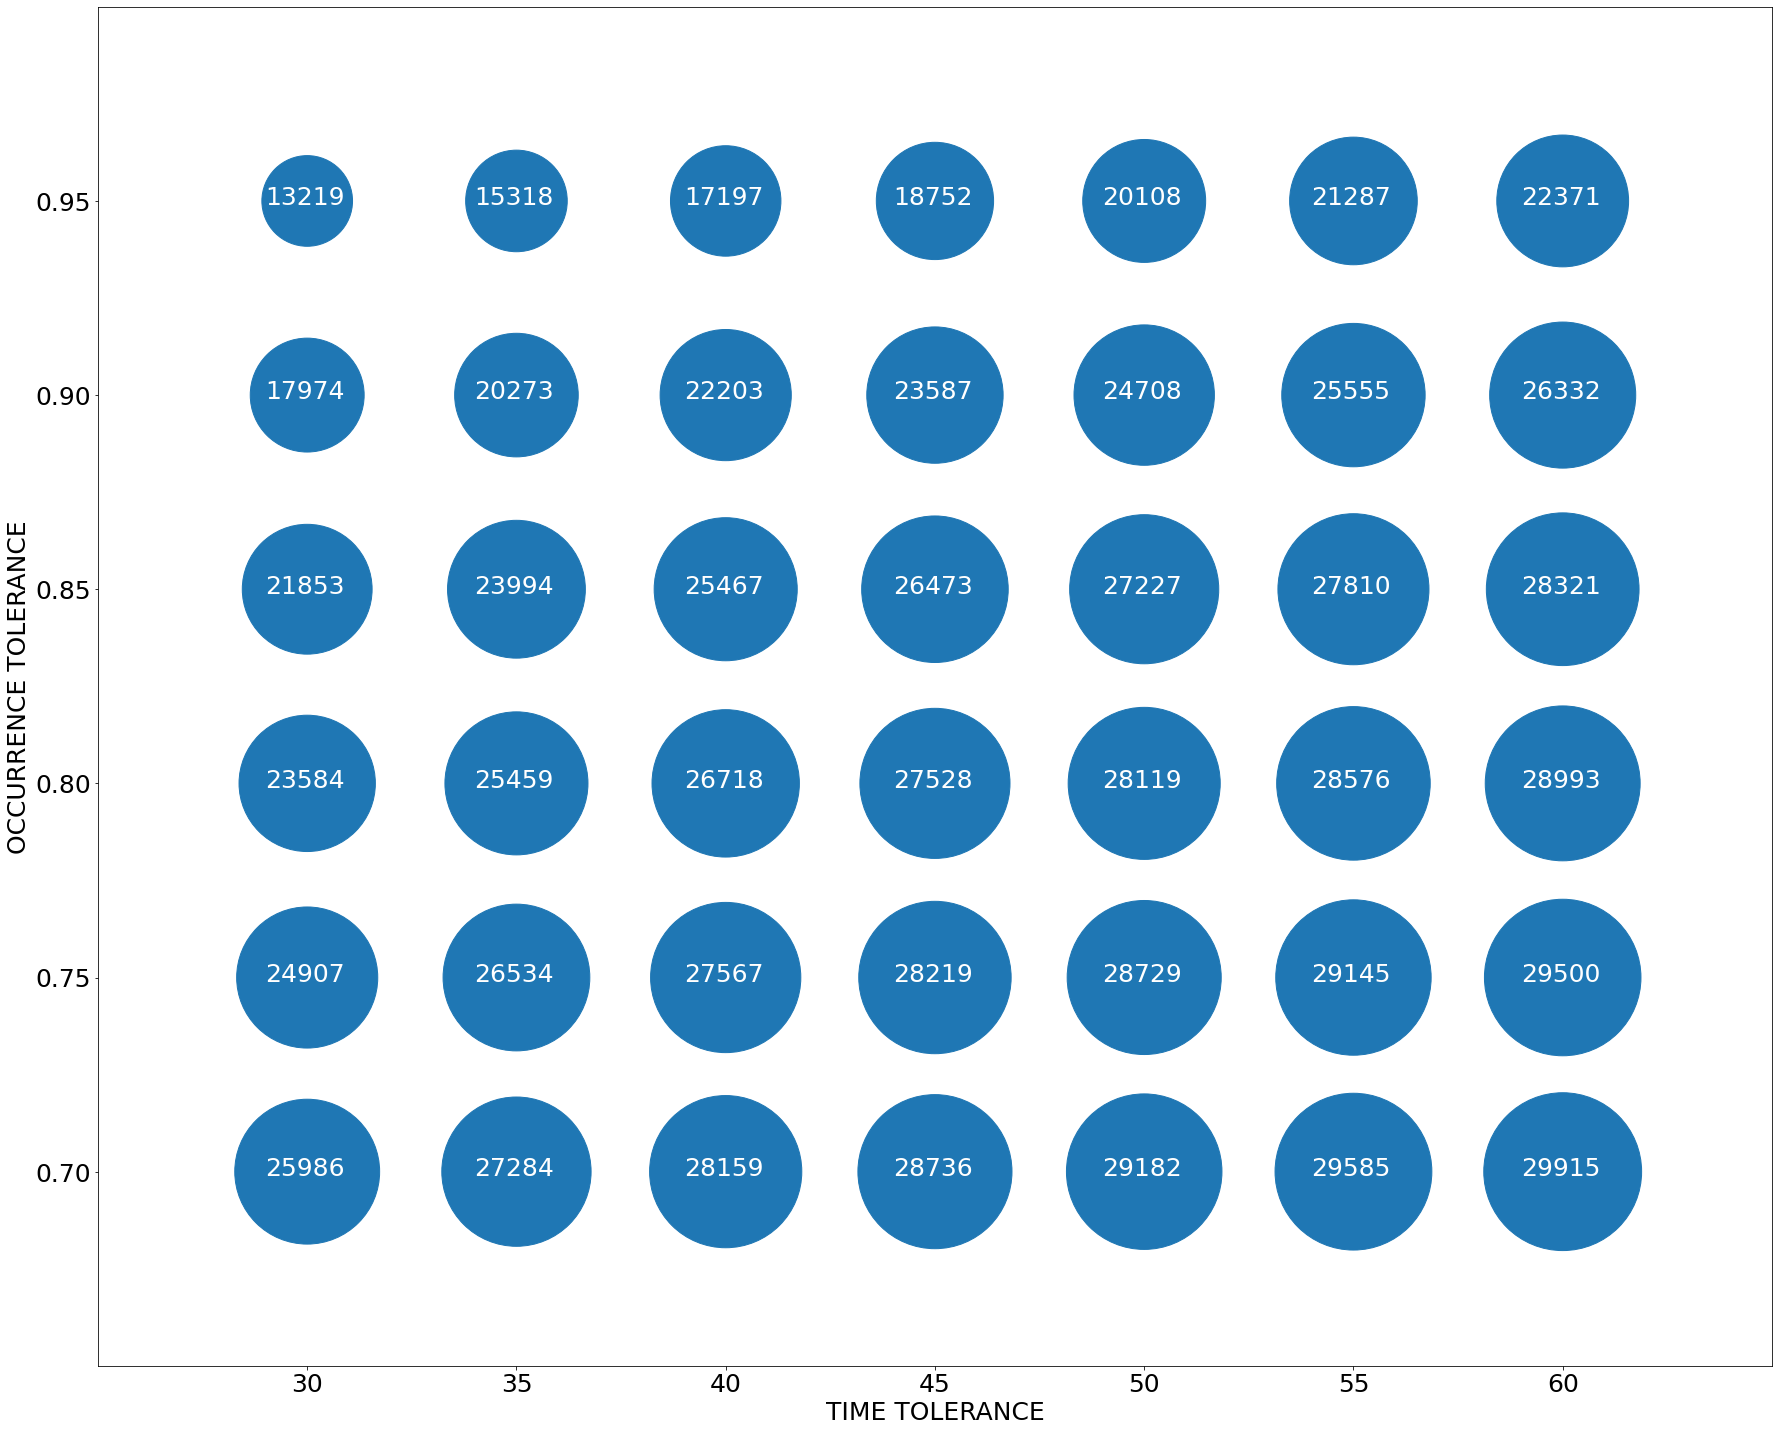

In [221]:
fls = np.array(fls)
plt.rcParams["figure.figsize"] = (30,25)
plt.rcParams["font.size"] = 25
points = np.array(grid).T
plt.xticks(tol)
plt.yticks(min_oc)
plt.xlabel("TIME TOLERANCE")
plt.xlim(25,65)
plt.ylim(0.65,1)
plt.ylabel("OCCURRENCE TOLERANCE")
plt.title
for i in range(len(grid)):
    plt.annotate(fls[i],(grid[i][0]-1,grid[i][1]-0.001),color='white')
plt.scatter(points[0],points[1], s=fls-5000)
plt.savefig("tol.png")

## Per week day

In [45]:
day =["Monday", "Tuesday", "Wednesday", "Thursday","Friday", "Saturday", "Sunday"]
for j in range(7):
    departures_day =arrivals[arrivals["week day"]==j]
    flights_departure= departures_day["callsign"].unique()
    print(flights_departure.shape)
    len_slice = flights_departure.shape[0]//num_procs
    split_fl = [i*len_slice for i in range(num_procs)] + [flights_departure.shape[0]]
    fls = []
    t = time.time()
    for point in grid:
        partial_time = time.time()
        print(point)
        time_tolerance = point[0]
        min_occourrency = point[1]
        split_flights = tuple([(flights_departure[split_fl[i]:split_fl[i+1]], departures_day[departures_day["callsign"].isin(flights_departure[split_fl[i]:split_fl[i+1]])], time_tolerance,min_occourrency) for i in range(num_procs)])
        pool = Pool(num_procs)
        fls.append(sum(pool.map(compute, split_flights)))
        pool.close()
        pool.join()
        print("paritial", time.time()-partial_time)

    print("time total: ",time.time()-t)

    fls = np.array(fls)
    plt.rcParams["figure.figsize"] = (30,25)
    plt.rcParams["font.size"] = 25
    points = np.array(grid).T
    plt.xticks(tol)
    plt.yticks(min_oc)
    plt.xlabel("TIME TOLERANCE")
    plt.xlim(25,65)
    plt.ylim(0.65,1)
    plt.ylabel("OCCURRENCE TOLERANCE")
    plt.title(day[j])
    for i in range(len(grid)):
        plt.annotate(fls[i],(grid[i][0],grid[i][1]),color='white',horizontalalignment='center',verticalalignment='center')
    plt.scatter(points[0],points[1], s=fls*1.5)
    plt.savefig("plots/arrivals_"+day[j]+".png")
    plt.cla()
    plt.clf()
    plt.close()
    print(j)

(10654,)
(30, 0.7)
paritial 3.268618106842041
(30, 0.75)
paritial 3.5356905460357666
(30, 0.8)
paritial 3.262927770614624
(30, 0.85)
paritial 3.3390684127807617
(30, 0.9)
paritial 3.397270917892456
(30, 0.95)
paritial 3.379070281982422
(35, 0.7)
paritial 3.322474241256714
(35, 0.75)
paritial 3.409468650817871
(35, 0.8)
paritial 3.2945594787597656
(35, 0.85)
paritial 3.4410104751586914
(35, 0.9)
paritial 3.2704081535339355
(35, 0.95)
paritial 3.6102378368377686
(40, 0.7)
paritial 3.3046607971191406
(40, 0.75)
paritial 3.3257219791412354
(40, 0.8)
paritial 3.271488904953003
(40, 0.85)
paritial 3.3717129230499268
(40, 0.9)
paritial 3.2615456581115723
(40, 0.95)
paritial 3.4558417797088623
(45, 0.7)
paritial 3.4334850311279297
(45, 0.75)
paritial 3.359332323074341
(45, 0.8)
paritial 3.494723320007324
(45, 0.85)
paritial 3.5127968788146973
(45, 0.9)
paritial 3.470557451248169
(45, 0.95)
paritial 3.5088865756988525
(50, 0.7)
paritial 3.484624147415161
(50, 0.75)
paritial 3.552582025527954
(5

4
(8694,)
(30, 0.7)
paritial 2.641829013824463
(30, 0.75)
paritial 2.6378512382507324
(30, 0.8)
paritial 2.593731164932251
(30, 0.85)
paritial 2.625596046447754
(30, 0.9)
paritial 2.541412830352783
(30, 0.95)
paritial 2.5694775581359863
(35, 0.7)
paritial 2.5267088413238525
(35, 0.75)
paritial 2.5380351543426514
(35, 0.8)
paritial 2.613356113433838
(35, 0.85)
paritial 2.542051315307617
(35, 0.9)
paritial 2.6406304836273193
(35, 0.95)
paritial 2.6311328411102295
(40, 0.7)
paritial 2.543008327484131
(40, 0.75)
paritial 2.5868287086486816
(40, 0.8)
paritial 2.6293838024139404
(40, 0.85)
paritial 2.5886759757995605
(40, 0.9)
paritial 2.5501813888549805
(40, 0.95)
paritial 2.6127769947052
(45, 0.7)
paritial 2.7099709510803223
(45, 0.75)
paritial 2.6116321086883545
(45, 0.8)
paritial 2.5609891414642334
(45, 0.85)
paritial 2.672106981277466
(45, 0.9)
paritial 2.6080353260040283
(45, 0.95)
paritial 2.5324344635009766
(50, 0.7)
paritial 2.5704407691955566
(50, 0.75)
paritial 2.5948004722595215


In [42]:
arrivals

,icao24,dep time,departure,arr time,arrival,callsign,dep dist,dep alt,arr dist,arr alt,candidate dep airports,candidate arr airports,day,week day,series code,series,arr time minute
0,4cc2a7,1.558355e+09,EBBR,17:11:12,BIKF,ICE67K,935.0,42.0,2909.0,39.0,2,0,2019-05-20,0,EBBR_BIKF_ICE67K _0,0,1032
1,4cc2a2,1.559569e+09,EBBR,18:20:29,BIKF,ICE67K,792.0,2.0,2624.0,69.0,2,0,2019-06-03,0,EBBR_BIKF_ICE67K _0,0,1103
2,4cc27b,1.560169e+09,EBBR,17:01:26,BIKF,ICE67K,1511.0,96.0,4266.0,69.0,2,0,2019-06-10,0,EBBR_BIKF_ICE67K _0,0,1024
3,4cc277,1.560775e+09,EBBR,17:17:20,BIKF,ICE67K,918.0,40.0,2650.0,92.0,2,0,2019-06-17,0,EBBR_BIKF_ICE67K _0,0,1039
4,3412d3,1.561983e+09,EBBR,17:30:15,BIKF,ICE67K,487.0,33.0,3049.0,6.0,2,0,2019-07-01,0,EBBR_BIKF_ICE67K _0,0,1052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248337,506c21,1.567965e+09,EDDM,20:21:58,LSZH,ADR33D,2210.0,171.0,385.0,50.0,0,7,2019-09-08,6,LSZH_EDDM_ADR33D _6,73151,1227
1248338,506c21,1.568569e+09,EDDM,20:19:59,LSZH,ADR33D,1821.0,49.0,737.0,88.0,0,7,2019-09-15,6,LSZH_EDDM_ADR33D _6,73151,1225
1248339,71c251,1.567952e+09,LOWW,17:17:27,LSZH,KAL9575,1525.0,38.0,1783.0,42.0,0,7,2019-09-08,6,LSZH_LOWW_KAL9575 _6,73152,1040
1248340,71c251,1.568559e+09,LOWW,17:49:26,LSZH,KAL9575,777.0,83.0,1875.0,88.0,0,7,2019-09-15,6,LSZH_LOWW_KAL9575 _6,73152,1072


## Global std

In [47]:
def compute_std(tup):
    fl_dep, dep, tolerance = tup
    std_list = []
    
    for flight in fl_dep:
        f = dep[dep["callsign"]==flight]["dep time minute"]
        mean, std = f.mean(), f.std()
        std_list.append(std)

    return std_list

In [50]:


t = time.time()

pool = Pool(num_procs)
reg = pool.map(compute_std, split_fl)
pool.close()
pool.join()
print(time.time()-t)


9.776390552520752
